In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


To run this notebook, you will need:
 
 * [astropy](https://pypi.python.org/pypi/astropy)
 * [corner](https://pypi.python.org/pypi/corner/2.0.1)
 * [pystan](https://pypi.python.org/pypi/pystan/2.12.0.0) (2.12.0.0, I think is the minimum, because I make use of some new features.)
 * [seaborn](https://pypi.python.org/pypi/seaborn/0.7.1)

In [313]:
import astropy.cosmology as cosmo
import astropy.units as u
import bz2
import corner
import pickle
import pystan
import seaborn as sns

In [221]:
sns.set_context("notebook")
sns.set_style("ticks")
sns.set_palette("colorblind")

## Draw Some Data

The below is a function to produce shear profiles of NFW halos that represent clusters.

In [3]:
def NFW(r, M200, c200, zl, zs):
    """
    Return the weak-lensing shear for a cluster.
    
    :param r: Radii (Mpc) at which shear is to be calculated.
    :type r: array-like
    
    :param M200: Cluster mass (Msun).
    :type r: real
    
    :param c200: Cluster concentration relative to `M200`.
    :type c200: real
    
    :param zl: Redshift of the lensing cluster.
    :type zl: real
    
    :param zs: Redshift of background galaxies that are used to compute shear.
    :type zs: real
    
    :return: Array of computed shear values at corresponding `r`.    
    """
    
    #set cosmology
    h    = 0.7                          #hubble parameter
    Ho   = h*100.0                      #km s^-1 Mpc-1
    Om   = 0.28                         #cosmological parameter
    Ol   = 0.72                         #cosmological parameter
    c    = 299792.0                     #speed of light in km/s
    Mpc  = 3.0856e19                    #1Mpc in km
    cMpc = c/Mpc                        #speed of light in Mpc/s
    pc   = 3.0856e16                    #1pc in m
    Msun = 1.989e30                     #1Msolar in kg
    G    = 6.6726e-11                   #G in m^3 kg-1 s-2
    GG   = G*(pc**(-3.0))*(1e-18)*Msun    #G in Mpc^3 Msun^-1 s^-2
    Ez   = np.sqrt(Om*(1.0+zl)**3.0+Ol) #evolution
    pcrit= 3.0*((Ho*Ez/Mpc)**2.0)/(8.0*np.pi*GG)
    
    #calculate angular diameter distances in Mpc to lens and source
    dL = cosmo.Planck15.angular_diameter_distance(zl).to(u.Mpc).value
    dS = cosmo.Planck15.angular_diameter_distance(zs).to(u.Mpc).value
    dLS =   (dS*(1.0+zs)-dL*(1.0+zl))/(1.0+zs)

    sigmacr=cMpc**2.0*dS/(4.0*GG*np.pi*dL*dLS)    #mean critical surface mass density in units Mpc^-2 Msolar
    
    p200    =   200.0*pcrit                         #density that is 200 times critical
    p500    =   500.0*pcrit                         #density that is 500 times critical
    r200    =   (3.0*M200/(4.0*np.pi*p200))**(1.0/3.0)     #radius within which the density is 200 times critical
    
    rs      =   r200/c200               #characteristic radius in Mpc
    ps      =   (p200*c200**3.0)/(3.0*(np.log(1.0+c200)-c200/(1.0+c200)))   #core density in Msolar Mpc-3

    r = np.atleast_1d(r)

    term = np.where(r <= rs, \
                    2.0*np.arctanh(np.sqrt((1.0-(r/rs))/(1.0+(r/rs))))/(np.sqrt(1.0-np.square(r/rs))), \
                    2.0*np.arctan(np.sqrt(((r/rs)-1.0)/(1.0+(r/rs))))/(np.sqrt(np.square(r/rs)-1.0)))
    sigma = 2.0*rs*ps*(1.0-term)/((np.square(r/rs))-1.0)
    meansigma = 4.0*rs*ps*(term+np.log((r/rs)/2.0))/(np.square(r/rs))
    rhoNFW = ps/((r/rs)*np.square(1.0+r/rs))

    kappaNFW = sigma/sigmacr              #calculate convergence
    meankappaNFW = meansigma/sigmacr      #mean convergence
    gammaNFW = meankappaNFW-kappaNFW                   #calculate shear
    reducedshear = np.abs(gammaNFW)/(1.0-kappaNFW)        #calculate reduced shear

    return reducedshear

## Single NFW Test

Fit a single, high-SNR NFW halo.

In [252]:
m = 1e14
c = 3
zl = 0.5
zs = 1.0
dl = cosmo.Planck15.angular_diameter_distance(zl)
ds = cosmo.Planck15.angular_diameter_distance(zs)
dls = (ds*(1.0+zs)-dl*(1.0+zl))/(1.0+zs)

Generate a possible shear measurement (incl observational uncertainties), and plot it:

<Container object of 3 artists>

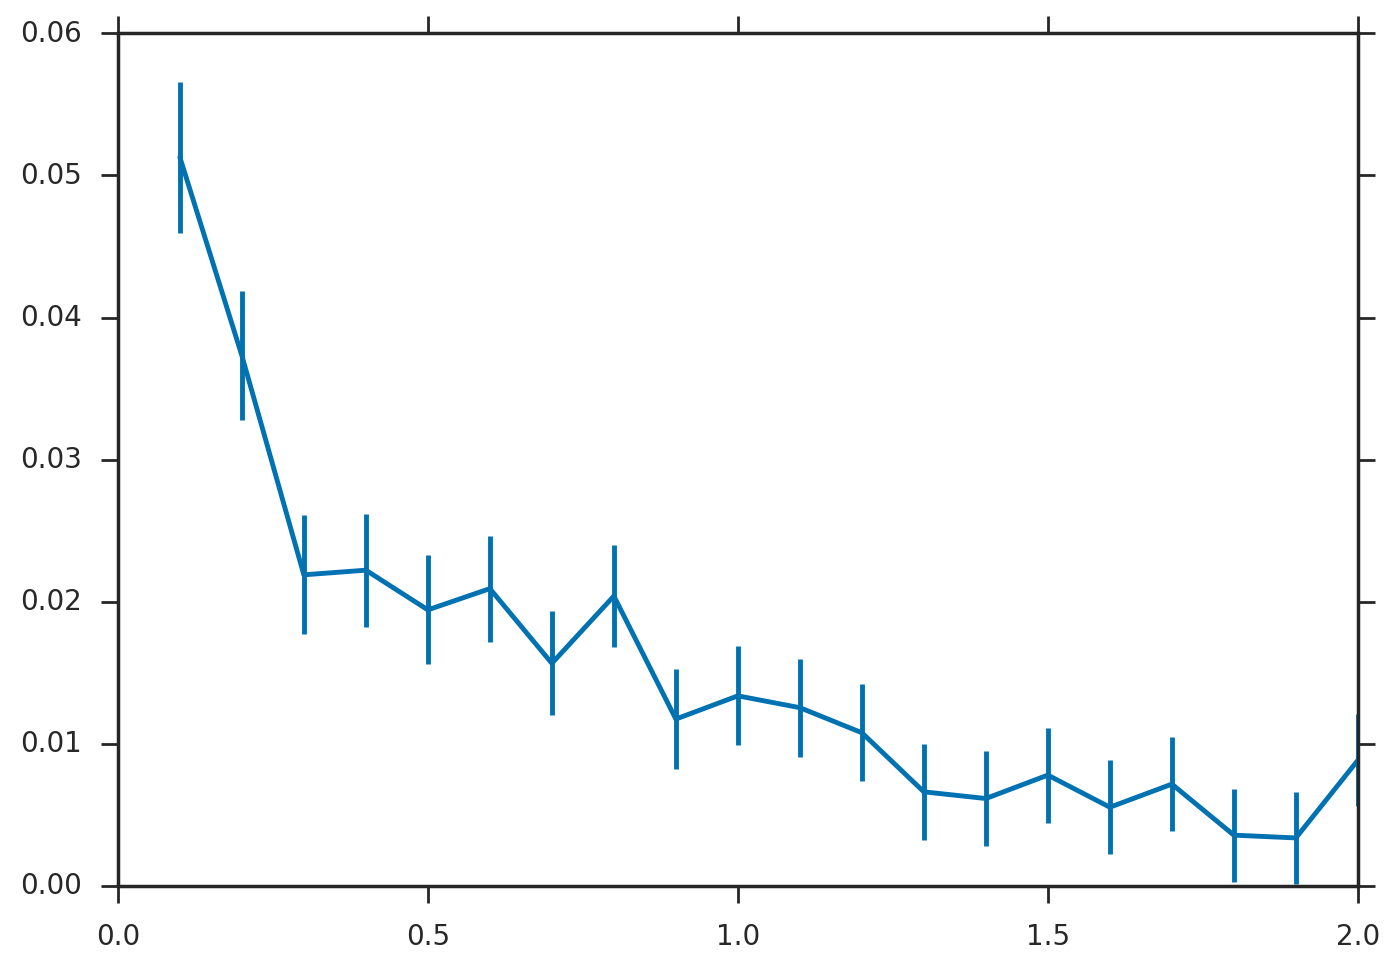

In [253]:
rs = linspace(0, 2, 21)[1:]
kappas = NFW(rs, m, c, zl, zs)
sk0 = kappas[0] / 10 # 10-sigma detection
sigma_kappas = 0.5*sk0*sqrt(rs[0]/rs) + 0.5*sk0
kappas = abs(kappas + sigma_kappas*randn(rs.shape[0]))
errorbar(rs, kappas, sigma_kappas)

Data and fit from Stan:

In [254]:
data = {'nr': len(rs),
        'rs': rs,
        'kappas': kappas,
        'sigma_kappas': sigma_kappas,
        'zl': zl,
        'zs': zs,
        'zls': zls,
        'dl': dl,
        'ds': ds,
        'dls': dls}
fit = pystan.stan(file='nfw.stan', data=data)
chains = fit.extract(permuted=True)
fit

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_6299839634763b6ad03bbcc725e2eb80 NOW.


Inference for Stan model: anon_model_6299839634763b6ad03bbcc725e2eb80.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                   mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
logM              32.33  3.1e-3   0.12   32.1  32.25  32.33  32.41  32.56   1517    1.0
logC               0.89  3.7e-3   0.13   0.63   0.81    0.9   0.98   1.14   1295    1.0
model_kappas[0]    0.05  9.5e-5 4.1e-3   0.04   0.04   0.05   0.05   0.05   1901    1.0
model_kappas[1]    0.04  4.6e-5 2.3e-3   0.03   0.03   0.04   0.04   0.04   2627    1.0
model_kappas[2]    0.03  2.5e-5 1.6e-3   0.03   0.03   0.03   0.03   0.03   4000    1.0
model_kappas[3]    0.02  1.9e-5 1.2e-3   0.02   0.02   0.02   0.03   0.03   4000    1.0
model_kappas[4]    0.02  2.1e-5 1.1e-3   0.02   0.02   0.02   0.02   0.02   2696    1.0
model_kappas[5]    0.02  2.2e-5 1.0e-3   0.02   0.02   0.02   0.02   0.02   2147    1.0
model_kappas[6]    

Parameter values look reasonable (try eliminating observational noise above, and you will see that truth lands exactly at the peak of the distribution, as it should).

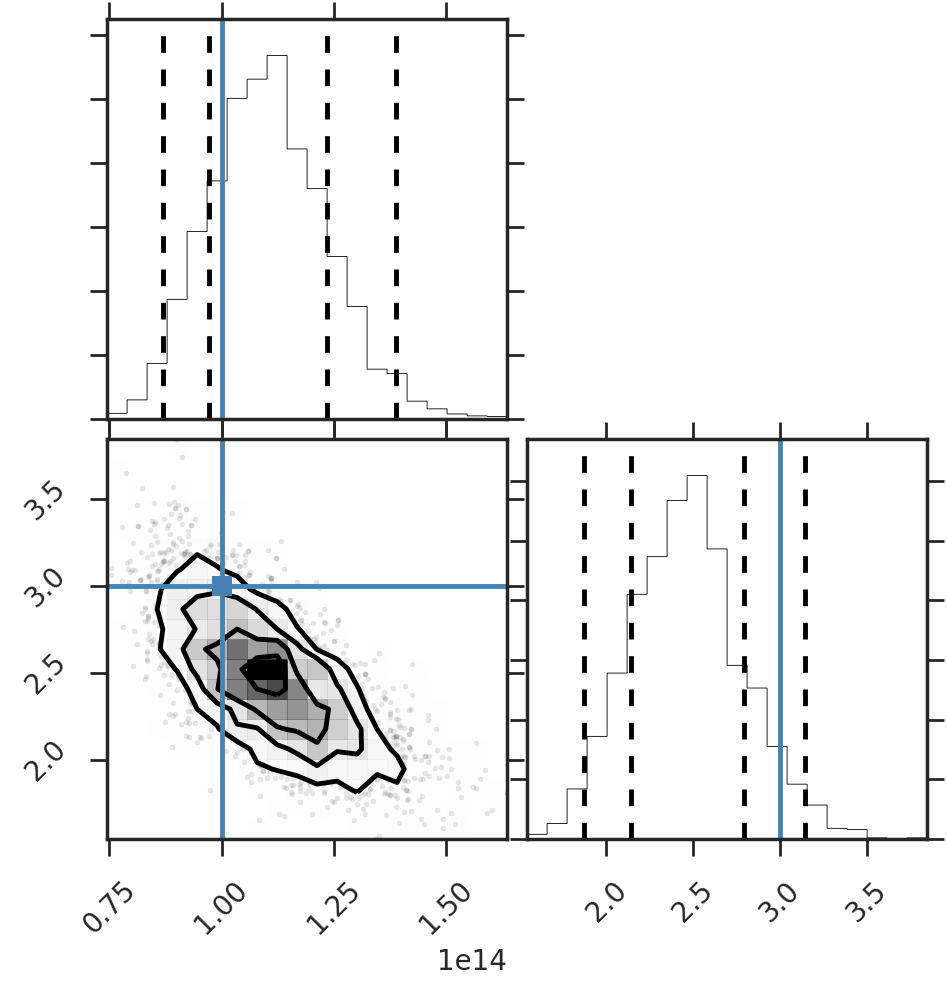

In [255]:
corner.corner(column_stack((chains['M'], chains['C'])), truths=[m,c], quantiles=[0.025, 0.16, 0.84, 0.975])
None

The posterior (median, one-, and two-sigma bands) on the shear profile plotted against the data.  Seems like a good fit.

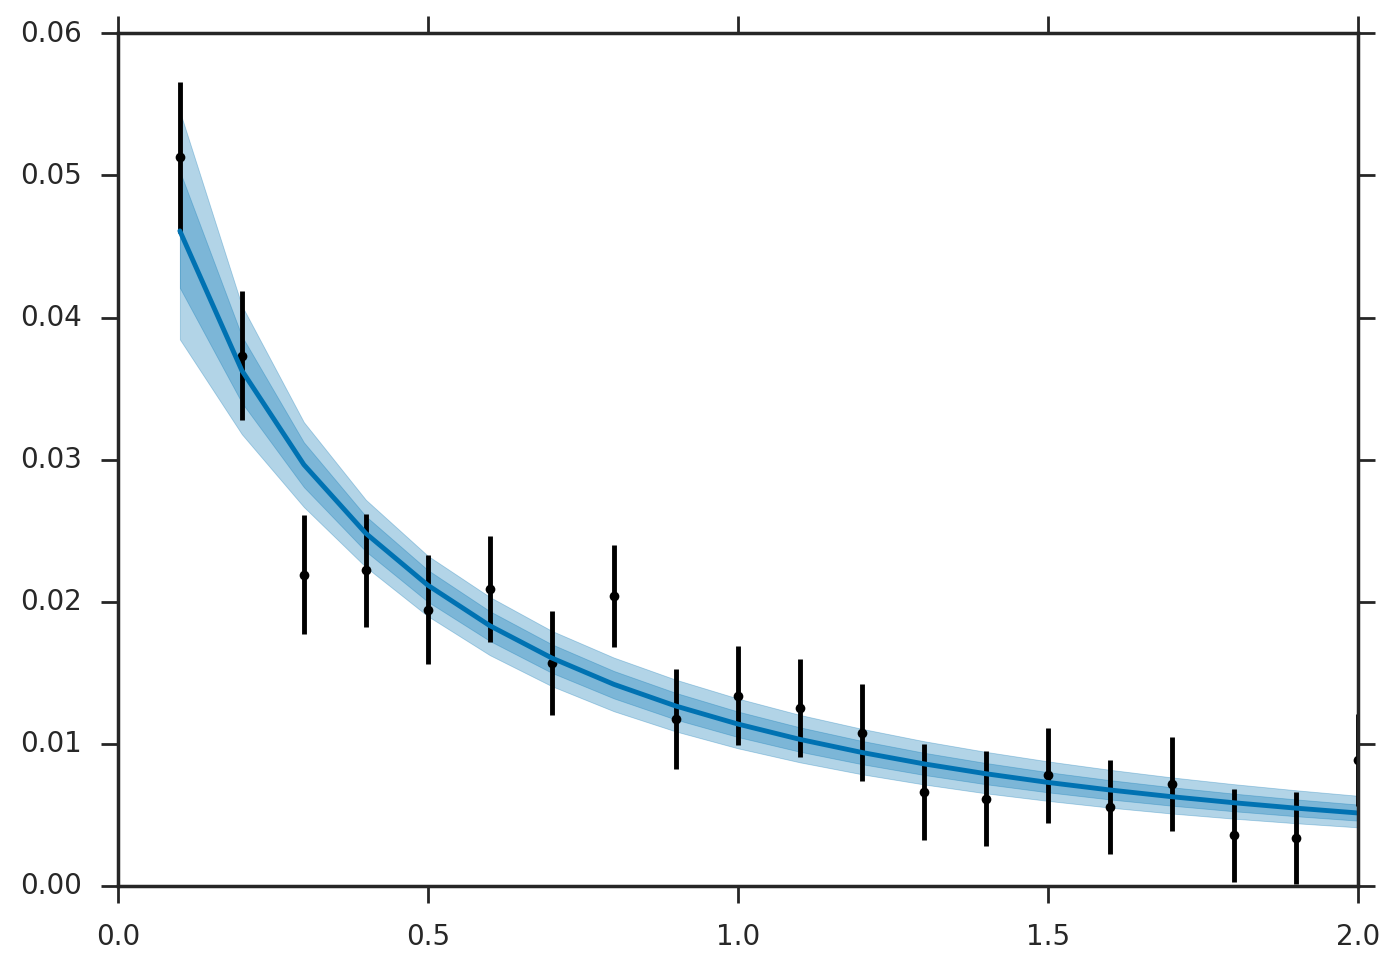

In [256]:
errorbar(rs, kappas, sigma_kappas, fmt='.k')
mks = chains['model_kappas']
med = median(mks, axis=0)
high = percentile(mks, 84, axis=0)
low = percentile(mks, 16, axis=0)
hhigh = percentile(mks, 97.5, axis=0)
llow = percentile(mks, 2.5, axis=0)
plot(rs, med, color=sns.color_palette()[0])
fill_between(rs, high, low, color=sns.color_palette()[0], alpha=0.3)
fill_between(rs, hhigh, llow, color=sns.color_palette()[0], alpha=0.3)

## 40 NFW Test

40 high-SNR NFW halos.  They are drawn from the following distribution:

 * Masses uniform in $\log M$ between $10^{13} \, M_\odot$ and $10^{15} \, M_\odot$.
 * Lens (cluster) redshifts uniform in $0.05$ to $0.6$.
 * Source redshift 1.0.
 * Concentration follows 
 $$
 c \sim N\left( e^{3.43} M^{-0.1} (1+z)^{2.60}, 0.05\right),
 $$
 which is the reported fit from our paper draft.
 
This results in the $M$--$c$ relation exhibited below:

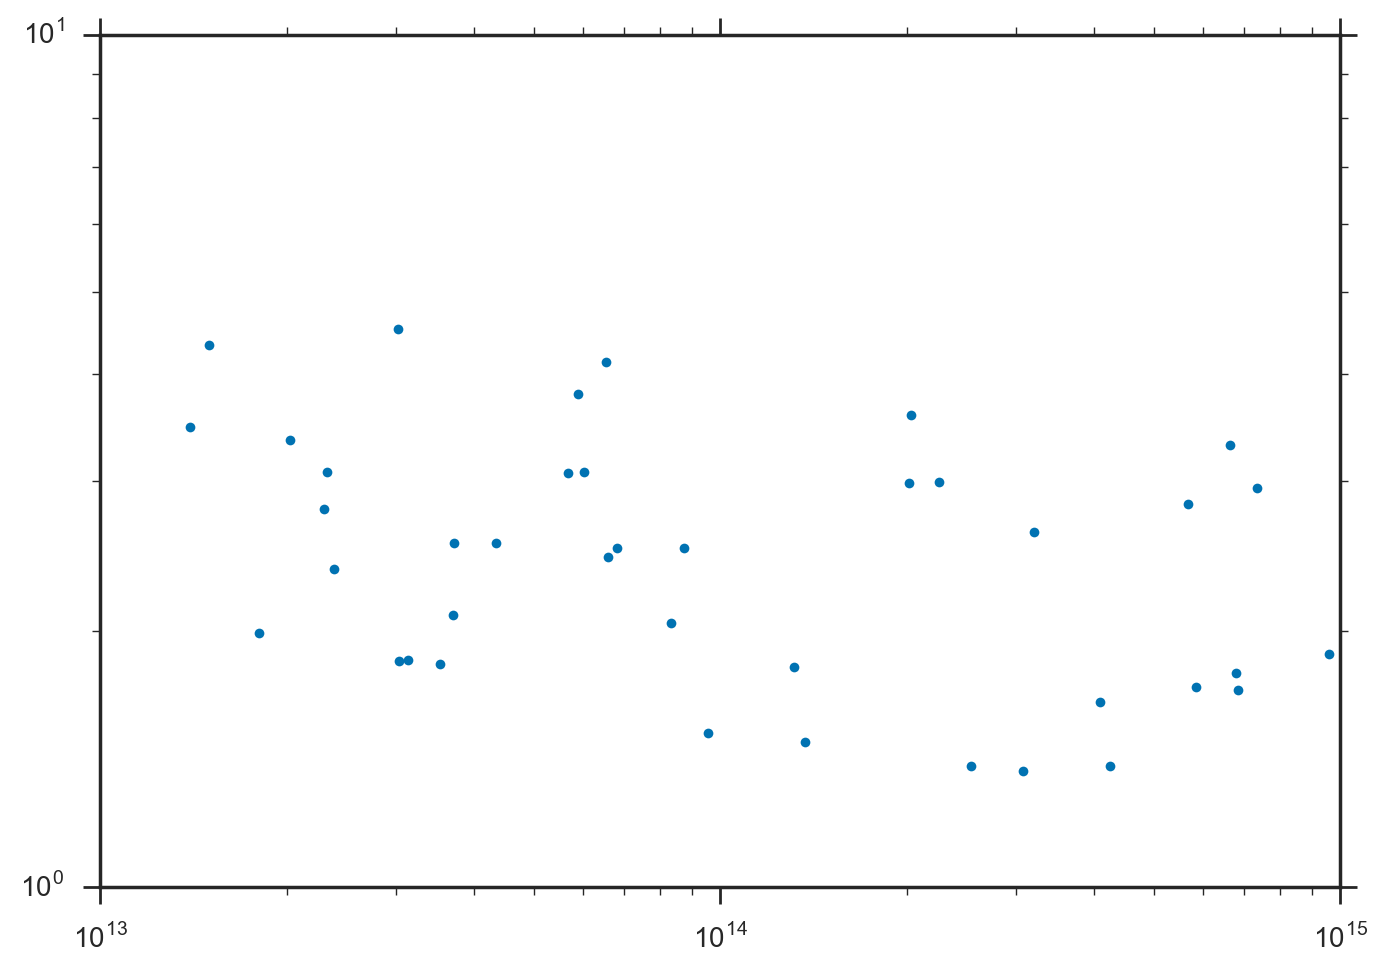

In [257]:
nc = 40
ms = exp(log(1e13) + log(100)*rand(nc))
zls = random.uniform(0.05, 0.6, nc)
zss = ones(nc)
cs = exp(3.43)*ms**-0.1*(1+zls)**2.60 + 0.05*randn(nc)
dls = cosmo.Planck15.angular_diameter_distance(zls)
dss = cosmo.Planck15.angular_diameter_distance(zss)
dlss = (dss*(1.0+zss)-dls*(1.0+zls))/(1.0+zss)
loglog(ms, cs, '.')

Now generate some data.  The observational uncertainites are generated in the following way:

 * We ensure a 10-sigma (!) shear detection in the smallest radial bin.
 * Half of the uncertainty required for 10-sigma is attributed to galaxy count statistics, and the other half to a constant irreducable uncertainty.  
 * In other bins, the irreducable uncertainty is added to a factor that falls as $1/\sqrt(r)$ from increasing galaxy count numbers.  (NOTE: really these should probably be added in quadrature, and we should attribute half the *variance* of the first bin to each cause, since this is how errors work, but whatever.  This is just a way to make the errorbars decrease for a while and then bottom out at large $r$.)

In [258]:
rs = []
kappas = []
sigma_kappas = []
for i in range(nc):
    r = linspace(0, 2, 21)[1:]
    k = NFW(r, ms[i], cs[i], zls[i], zss[i])
    sk0 = k[0]/10 # 10-sigma detection
    sk = 0.5*sk0*sqrt(r[0]/r) + 0.5*sk0
    k = abs(k + sk*randn(r.shape[0]))
    rs.append(r)
    kappas.append(k)
    sigma_kappas.append(sk)

40 shear profiles:

(0.0, 2.0, 0.001, 1.0)

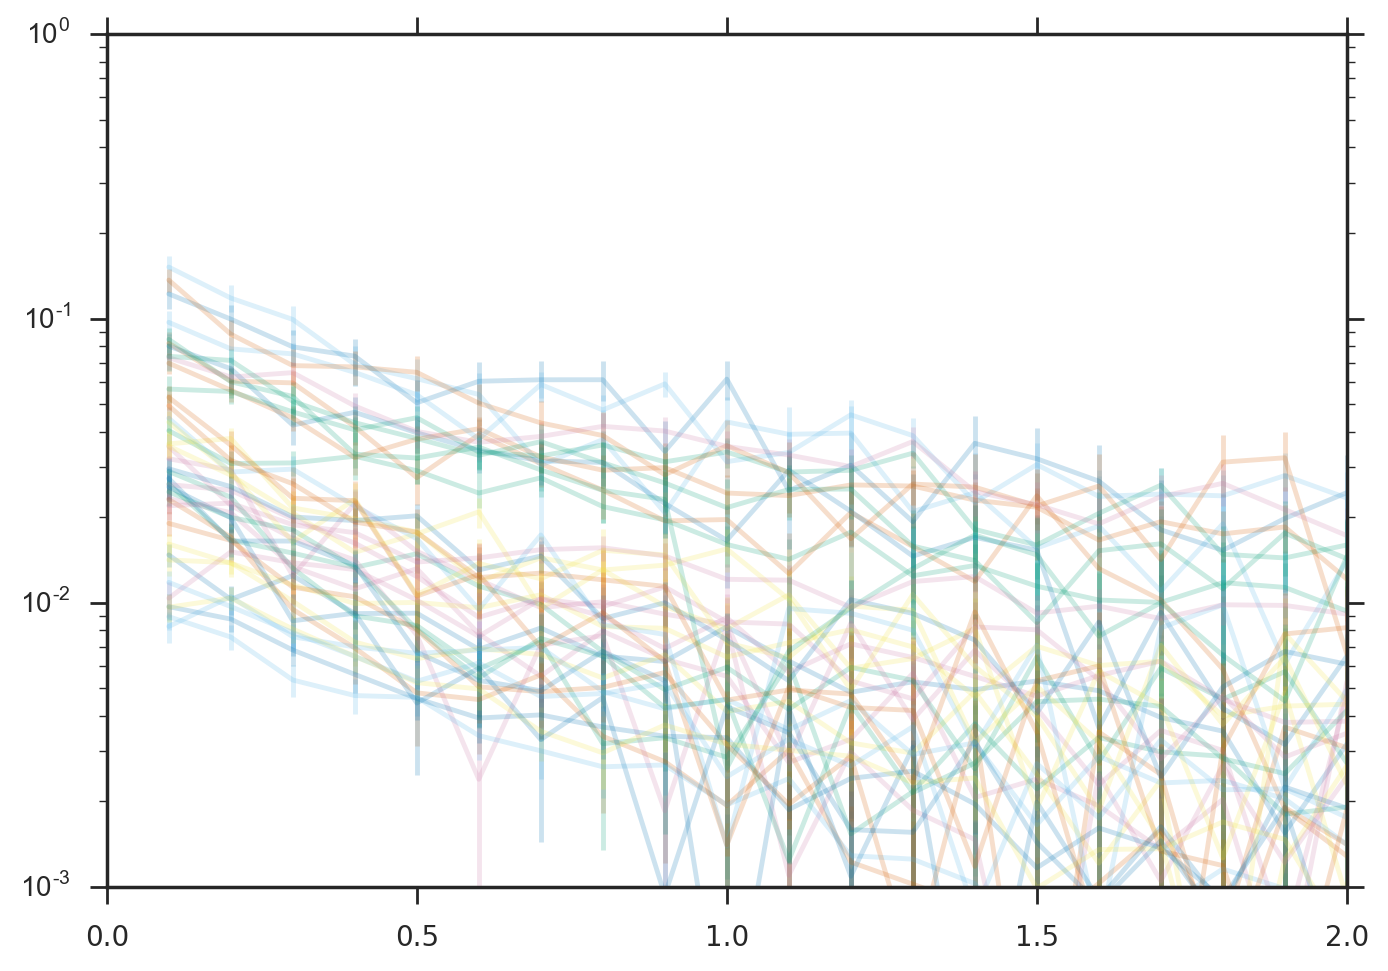

In [259]:
for r,k,s in zip(rs, kappas, sigma_kappas):
    errorbar(r,k,s, alpha=0.2)
yscale('log')
axis(ymin=1e-3)

Fit it in Stan.  I don't know why the `model_kappas` and `cl_params` have so many `NaN`s, or why the `Sigma` matrix has some `NaN`s in it, but the `logM` and `logC` parameters (the *actual* parameters the sampler jumps in) look well-converged, and traceplots (see below) don't show anything weird.  Fit took about an hour on my three-year-old macbook pro (four cores, one per chain).

In [291]:
data = {'nc': nc,
        'nr': len(rs[0]),
        'rs': rs,
        'kappas': kappas,
        'sigma_kappas': sigma_kappas,
        'zl': zls,
        'zs': zss,
        'dl': dls,
        'ds': dss,
        'dls': dlss,
        'mu0': [1e14, 3, 0.3]}
fit = pystan.stan(file='nfw_hier.stan', data=data)
chains = fit.extract(permuted=True)
fit

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_77aa396d742283d351a8d7a4a1fc5c85 NOW.


Inference for Stan model: anon_model_77aa396d742283d351a8d7a4a1fc5c85.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                      mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
logM[0]              32.16  7.7e-4   0.05  32.07  32.13  32.16   32.2  32.26   4000    1.0
logM[1]              32.97  8.6e-4   0.05  32.86  32.93  32.97   33.0  33.07   4000    1.0
logM[2]              32.97  1.1e-3   0.07  32.83  32.93  32.97  33.02   33.1   4000    1.0
logM[3]              31.51  9.6e-4   0.06  31.38  31.47  31.51  31.55  31.62   4000    1.0
logM[4]              31.43  8.9e-4   0.06  31.32  31.39  31.43  31.47  31.54   4000    1.0
logM[5]              33.56  1.5e-3    0.1  33.37   33.5  33.56  33.63  33.74   4000    1.0
logM[6]              33.53  1.5e-3   0.09  33.34  33.46  33.53  33.59  33.71   4000    1.0
logM[7]              31.71  9.6e-4   0.06  31.59  31.67  31.71  31.75  31.82   4000

The below code grabs a random cluster, and 10 random posterior samples from that cluster's modelled shear profile, and plots them.  You can see that the fits look good---run it a few times to check.

<Container object of 3 artists>

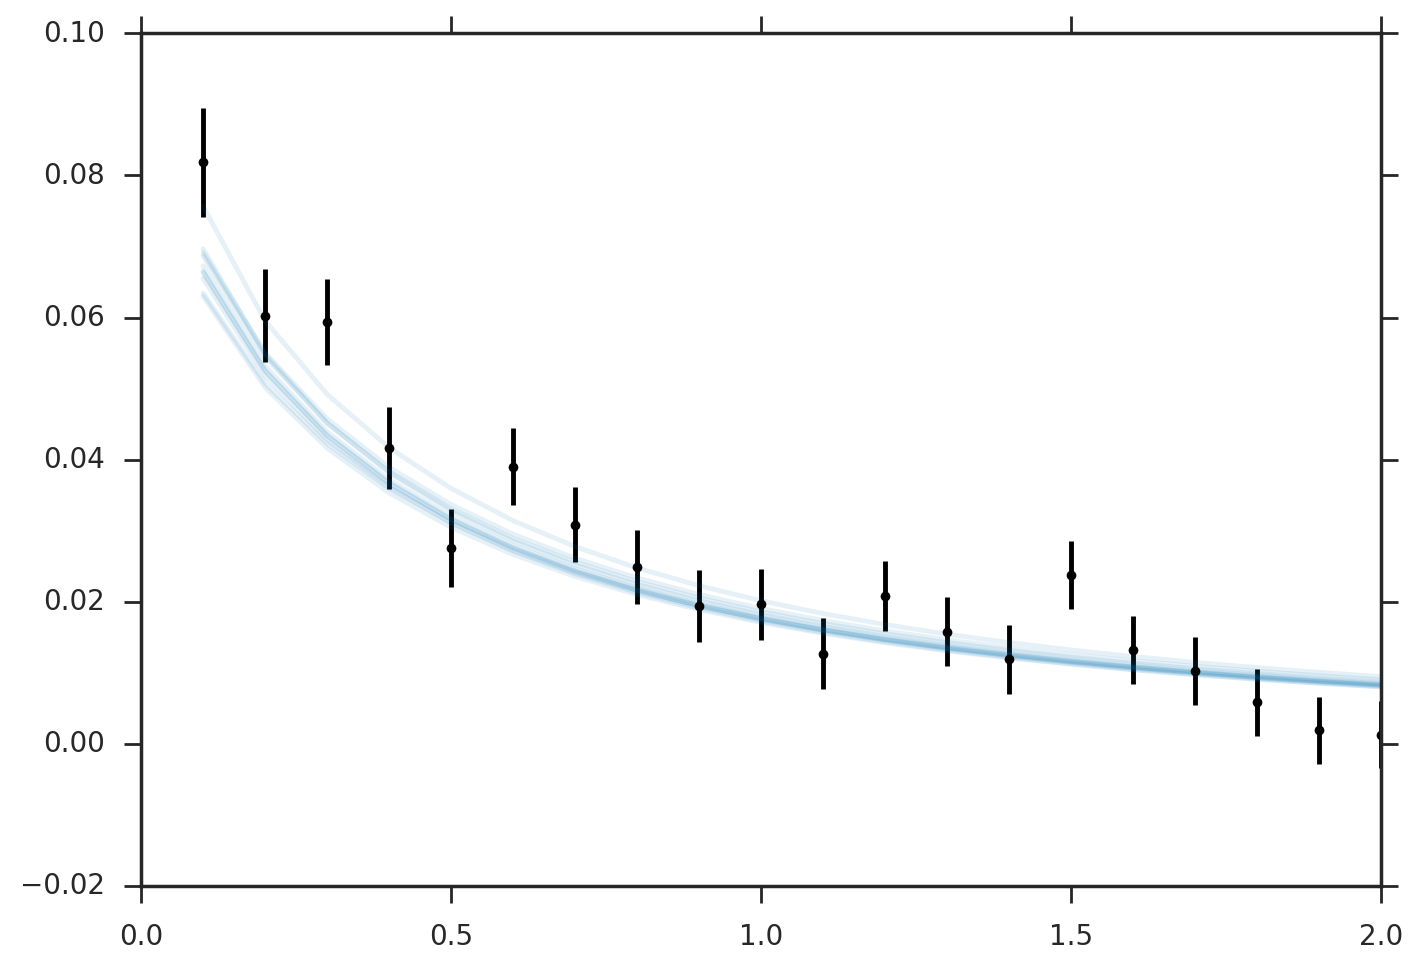

In [319]:
icl = randint(chains['model_kappas'].shape[1])
for j in range(10):
    mks = chains['model_kappas'][:, icl, :]
    isamp = randint(mks.shape[0])
    plot(data['rs'][icl], mks[isamp,:], alpha=0.1, color=sns.color_palette()[0])
errorbar(data['rs'][icl], data['kappas'][icl], data['sigma_kappas'][icl], fmt='.k')

Lots of traceplots, since `fit.traceplot()` seems to choke:

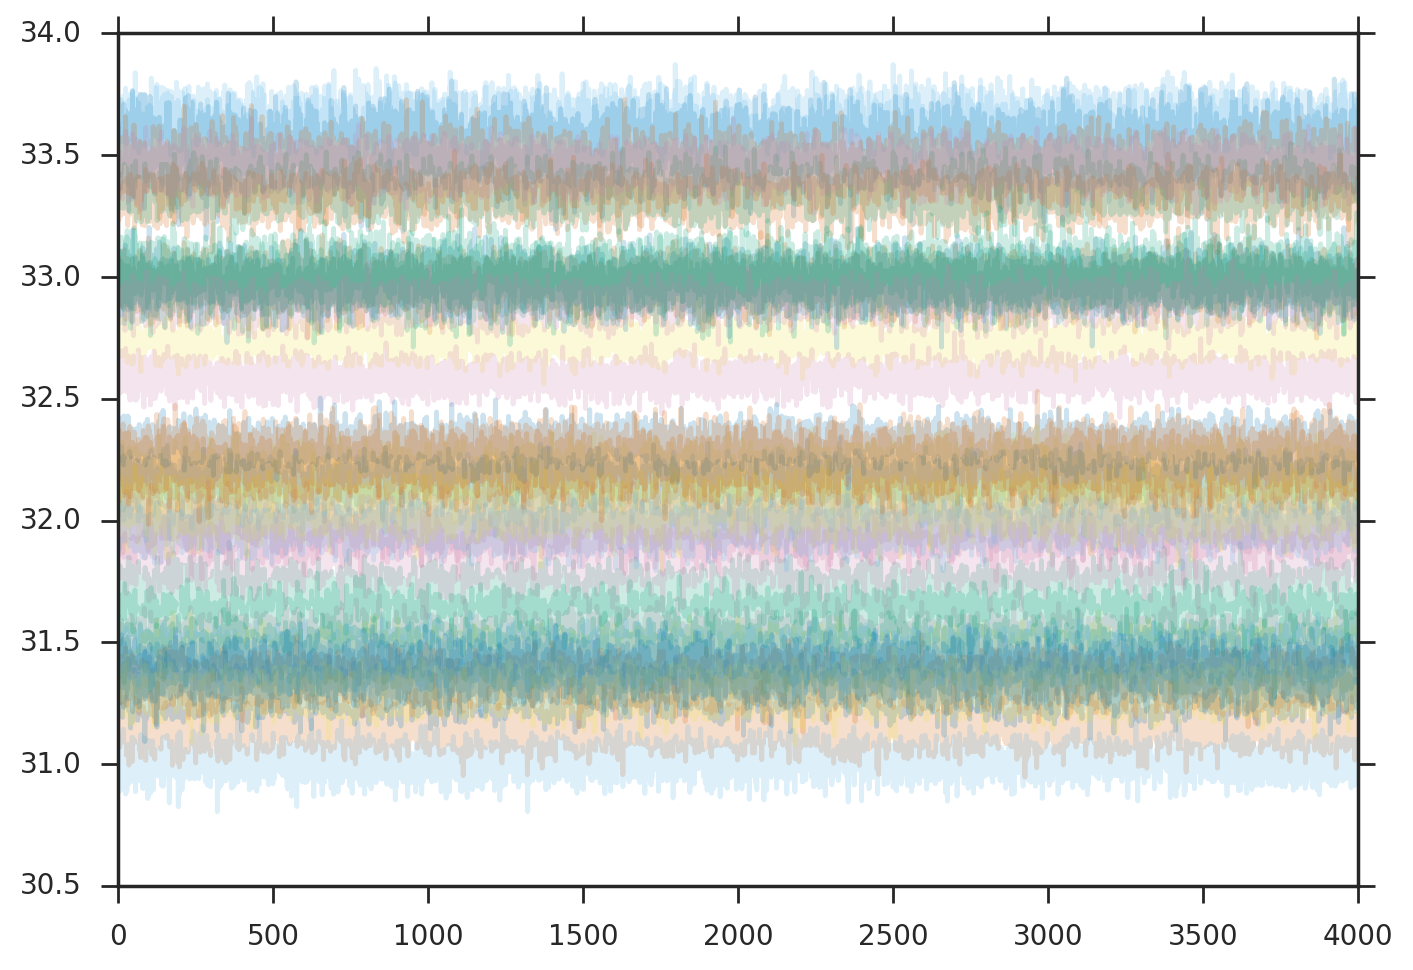

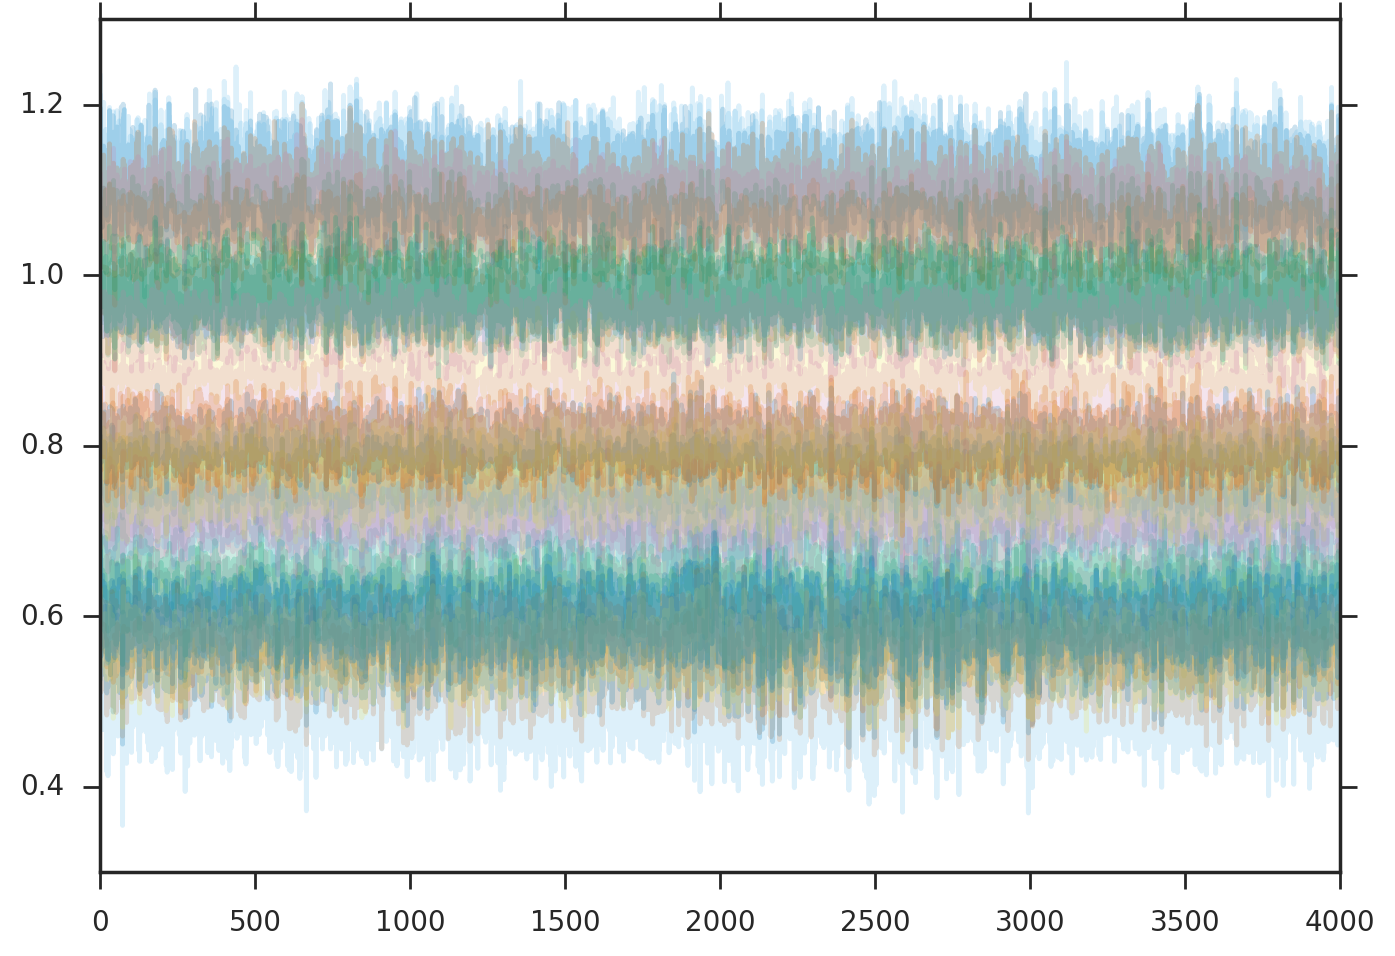

In [304]:
for i in range(nc):
    plot(chains['logM'][:,i], alpha=0.2)
figure()
for i in range(nc):
    plot(chains['logC'][:,i], alpha=0.2)

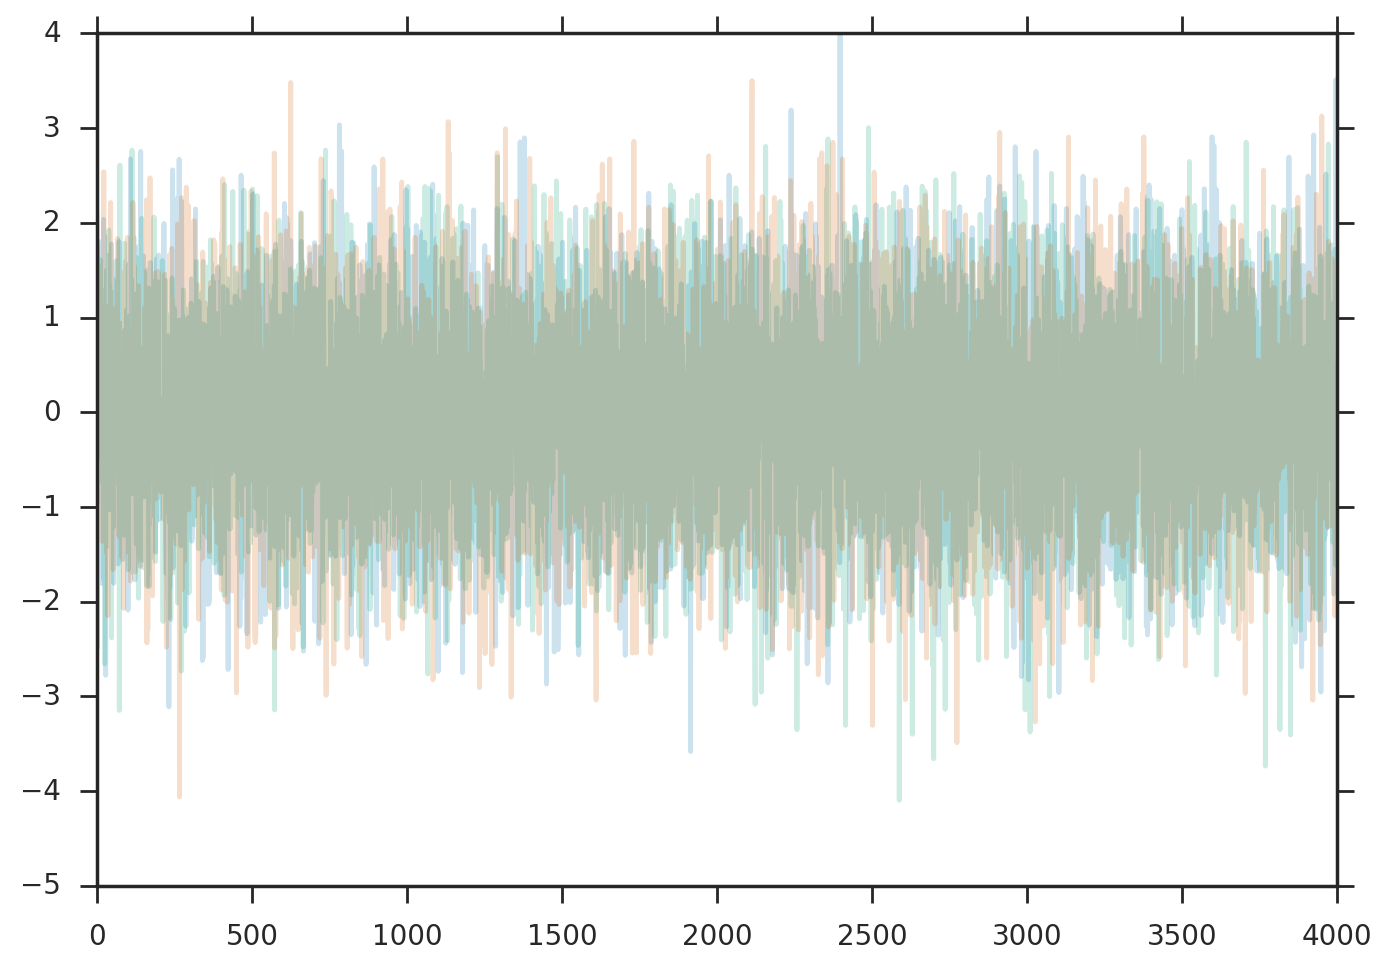

In [311]:
for i in range(3):
    plot((chains['mu'][:,i] - mean(chains['mu'][:,i]))/std(chains['mu'][:,i]), alpha=0.2)

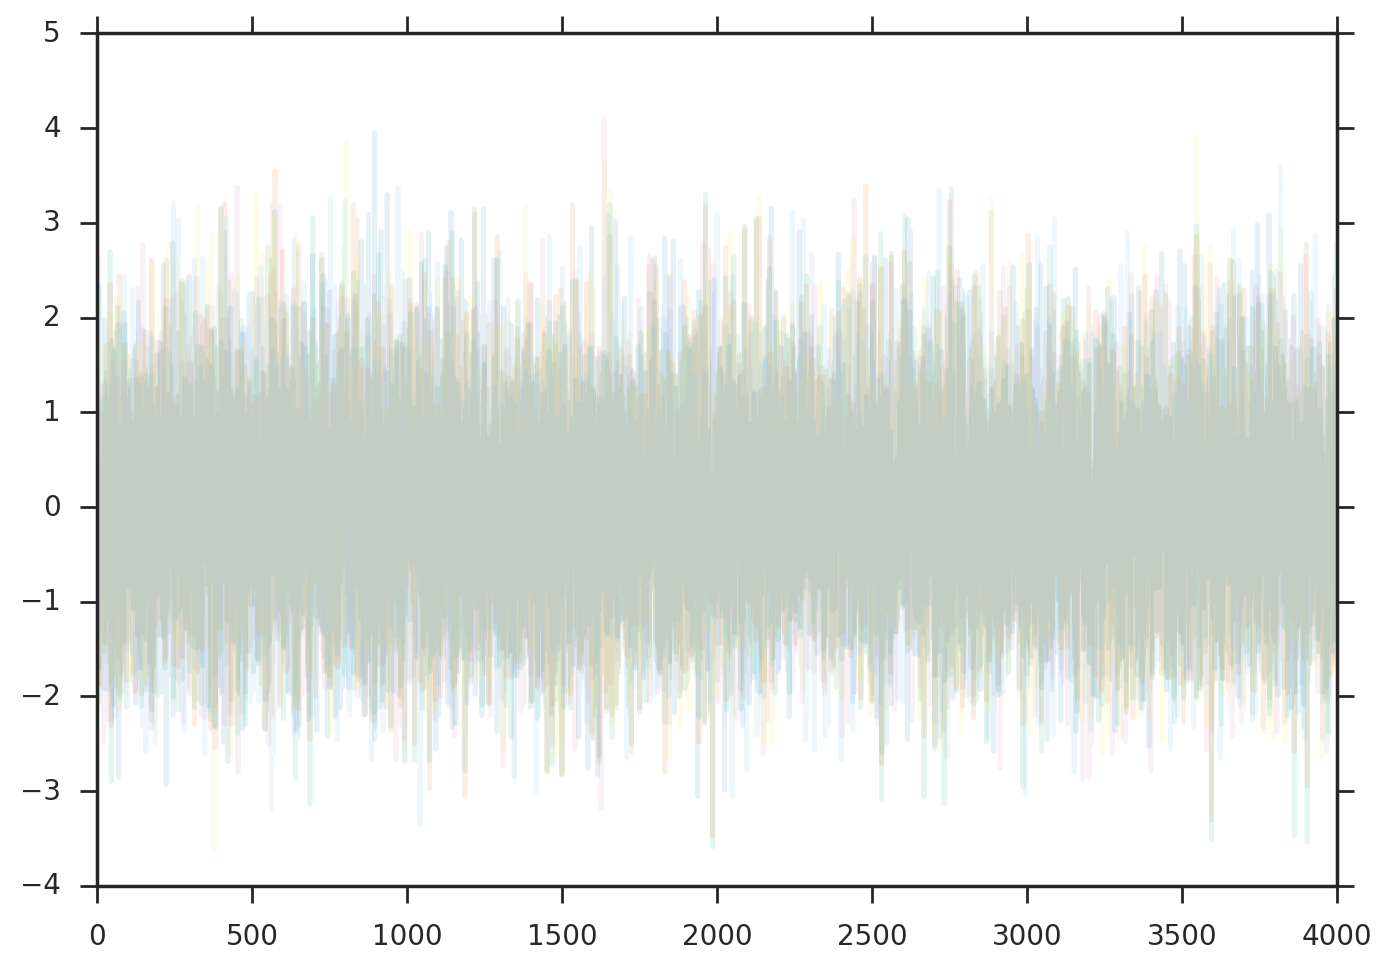

In [310]:
for i in range(3):
    for j in range(i+1):
        plot((chains['Sigma'][:,i,j] - mean(chains['Sigma'][:,i,j]))/(std(chains['Sigma'][:,i,j])), alpha=0.1)

Save all the stuff to bzipped pickle files:

In [316]:
with bz2.BZ2File("testchains.pkl.bz2", "w") as out:
    pickle.dump(chains, out)
with bz2.BZ2File("testdata.pkl.bz2", "w") as out:
    pickle.dump(data, out)
with bz2.BZ2File("testmodel.pkl.bz2", "w") as out:
    pickle.dump(fit.get_stanmodel(), out)
with bz2.BZ2File("testfit.pkl.bz2", "w") as out:
    pickle.dump(fit, out)

/Users/farr/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:8: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.


Execute this cell to load the saved fit (before executing the above cells).

In [ ]:
with bz2.BZ2File('testchains.pkl.bz2', 'r') as inp:
    chains = pickle.load(inp)
with bz2.BZ2File('testdata.pkl.bz2', 'r') as inp:
    data = pickle.load(inp)
with bz2.BZ2File('testmodel.pkl.bz2', 'r') as inp:
    model = pickle.load(inp)
with bz2.BZ2File('testfit.pkl.bz2', 'r') as inp:
    fit = pickle.load(inp)